In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt;
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import fuzz
from scipy.sparse import csr_matrix
import seaborn as sns

c:\Users\soni2\AppData\Local\Programs\Python\Python311\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
dfsongs = pd.read_csv("../../../train_triplets.txt", sep="\t", nrows=10000, names=['user', 'song', 'play_count'], header=None)

In [3]:
dfsongs.head(5)

,user,song,play_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1


In [4]:
from collections import defaultdict
usersDict = defaultdict(int)
with open("../../../train_triplets.txt", "r") as songFile:
    for record in songFile:
        #Fetch user id as the first item from a tab delimited line of record
        user = record.split("\t")[0]
        #Fetch song play count as the last item from a tab delimited line of record
        play_count = int(record.split("\t")[2])
        #Update song play count for all songs for a user
        usersDict[user] += play_count
        
userPlayCountList = [{'user': u, 'play_count': p} for u,p in usersDict.items()]
dfSongsPlayCount = pd.DataFrame(userPlayCountList)
#Arrange the user songs played records in descending order
dfSongsPlayCount = dfSongsPlayCount.sort_values(by = 'play_count', ascending = False)
dfSongsPlayCount.to_csv("songs_play_count.csv", index=None)
dfSongsPlayCount = pd.read_csv("songs_play_count.csv")

In [5]:
totalPlayCount = sum(dfSongsPlayCount.play_count)
(float(dfSongsPlayCount.head(n=100000).play_count.sum())/totalPlayCount)*100
dfUserSubset = dfSongsPlayCount.head(n=100000)

#This calculation is useful for understanding the distribution of plays among users. If the top 100,000 users represent a large percentage of total plays (e.g., more than 50%), then a recommendation system based on popular songs might be effective. If the top users represent a small percentage of total plays, then a recommendation system based on user preferences (e.g., collaborative filtering) might be more effective.

In [6]:
songsDict = defaultdict(int)
with open("../../../train_triplets.txt", "r") as songFile:
    for record in songFile:
        #Fetch song id as the first item from a tab delimited line of record
        song = record.split("\t")[1]
        #Fetch song play count as the last item from a tab delimited line of record
        play_count = int(record.split("\t")[2])
        #Update song play count for a song
        songsDict[song] += play_count
        
songPlayCountList = [{'song': s, 'play_count': p} for s,p in songsDict.items()]
dfSongsPlaySummary = pd.DataFrame(songPlayCountList)
#Arrange the user songs played records in descending order to facilitate further analysis
dfSongsPlaySummary = dfSongsPlaySummary.sort_values(by = 'play_count', ascending = False)
dfSongsPlaySummary.to_csv("songs_summary.csv", index=None)

In [7]:
(float(dfSongsPlaySummary.head(n=30000).play_count.sum())/totalPlayCount)*100

78.39315366645269

In [8]:
dfSongPlayCountSubset = dfSongsPlaySummary.head(n=30000)

In [9]:
dfAllSongs = pd.read_csv("../../../train_triplets.txt", sep="\t", names=['user', 'song', 'play_count'], header=None)
#Filter records for top 40% users using the users subset found earlier
dfSongsTopUsers = dfAllSongs[dfAllSongs.user.isin(list(dfUserSubset.user))]
dfSongsTopSongs = dfSongsTopUsers[dfSongsTopUsers.song.isin(list(dfSongPlayCountSubset.song))]

In [10]:
#Save the top 30 songs dataset to a file
dfSongsTopSongs.to_csv("top_Songs_Subset.csv", index=False)
#Find the number of records in this subset
dfSongsTopSongs.shape

(10774558, 3)

In [11]:
del dfAllSongs
del dfSongsTopUsers

In [12]:
dfSongsTopSongs.head(5)

,user,song,play_count
498,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOADQPP12A67020C82,12
499,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAFTRR12AF72A8D4D,1
500,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOANQFY12AB0183239,1
501,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAYATB12A6701FD50,1
502,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOBOAFP12A8C131F36,7


In [13]:
import sqlite3
#connect to SQL lite dataset 
conn = sqlite3.connect('../../.././MillionSongSubset/track_metadata.db')
cur = conn.cursor()
#The cursor() method creates a cursor object that can be used to execute SQL queries on the database
#Find the name of tables in the database
cur.execute("SELECT name FROM sqlite_master WHERE type='table'")
cur.fetchall()

[('songs',)]

In [14]:
#Retrieve details of song tracks from the metadata file
dfTrackMetadata = pd.read_sql(con=conn, sql='select * from songs')
dfTrackMetadata_sub = dfTrackMetadata[dfTrackMetadata.song_id.isin(list(dfSongPlayCountSubset.song))]

In [15]:
dfTrackMetadata_sub.head(3)

,track_id,title,song_id,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hotttnesss,year,track_7digitalid,shs_perf,shs_work
115,TRMMGCB128E079651D,Get Along (Feat: Pace Won) (Instrumental),SOHNWIM12A67ADF7D9,Charango,ARU3C671187FB3F71B,067102ea-9519-4622-9077-57ca4164cfbb,Morcheeba,227.47383,0.819087,0.533117,2002,185967,-1,0
123,TRMMGTX128F92FB4D9,Viejo,SOECFIW12A8C144546,Caraluna,ARPAAPH1187FB3601B,f69d655c-ffd6-4bee-8c2a-3086b2be2fc6,Bacilos,307.51302,0.595554,0.400705,0,6825058,-1,0
145,TRMMGDP128F933E59A,I Say A Little Prayer,SOGWEOB12AB018A4D0,The Legendary Hi Records Albums_ Volume 3: Ful...,ARNNRN31187B9AE7B7,fb7272ba-f130-4f0a-934d-6eeea4c18c9a,Al Green,133.58975,0.779490,0.599210,1978,5211723,-1,11898


In [16]:
# songdata = pd.read_csv('aidataset.csv')
# ratingdata = pd.read_csv('ratingdata.csv')


In [17]:
dfTrackMetadata_sub.head()

,track_id,title,song_id,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hotttnesss,year,track_7digitalid,shs_perf,shs_work
115,TRMMGCB128E079651D,Get Along (Feat: Pace Won) (Instrumental),SOHNWIM12A67ADF7D9,Charango,ARU3C671187FB3F71B,067102ea-9519-4622-9077-57ca4164cfbb,Morcheeba,227.47383,0.819087,0.533117,2002,185967,-1,0
123,TRMMGTX128F92FB4D9,Viejo,SOECFIW12A8C144546,Caraluna,ARPAAPH1187FB3601B,f69d655c-ffd6-4bee-8c2a-3086b2be2fc6,Bacilos,307.51302,0.595554,0.400705,0,6825058,-1,0
145,TRMMGDP128F933E59A,I Say A Little Prayer,SOGWEOB12AB018A4D0,The Legendary Hi Records Albums_ Volume 3: Ful...,ARNNRN31187B9AE7B7,fb7272ba-f130-4f0a-934d-6eeea4c18c9a,Al Green,133.58975,0.779490,0.599210,1978,5211723,-1,11898
172,TRMMHBF12903CF6E59,At the Ball_ That's All,SOJGCRL12A8C144187,Best of Laurel & Hardy - The Lonesome Pine,AR1FEUF1187B9AF3E3,4a8ae4fd-ad6f-4912-851f-093f12ee3572,Laurel & Hardy,123.71546,0.438709,0.307120,0,8645877,-1,0
191,TRMMHKG12903CDB1B5,Black Gold,SOHNFBA12AB018CD1D,Total Life Forever,ARVXV1J1187FB5BF88,6a65d878-fcd0-42cf-aff9-ca1d636a8bcc,Foals,386.32444,0.842578,0.514523,2010,9007438,-1,0


In [18]:
dfTrackMetadata_sub.drop_duplicates(['song_id'], inplace=True)
#Join the earlier obtained top popular songs dataset and this metadata dataframe on song id
dfPopularSongMetaDataMerged = pd.merge(dfSongsTopSongs, dfTrackMetadata_sub, how="left", 
                                      left_on="song", right_on = "song_id")
#Keep only relevant columns
dfPopularSongMetaDataMerged = dfPopularSongMetaDataMerged[['user', 'song', 'title',
                                                           'play_count', 'release', 'artist_name', 'year']]
dfPopularSongMetaDataMerged = dfPopularSongMetaDataMerged.rename(columns={'song': 'songid'})

dfPopularSongMetaDataMerged.head(3)

C:\Users\soni2\AppData\Local\Temp\ipykernel_22304\404006111.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfTrackMetadata_sub.drop_duplicates(['song_id'], inplace=True)


,user,songid,title,play_count,release,artist_name,year
0,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOADQPP12A67020C82,You And Me Jesus,12,Tribute To Jake Hess,Jake Hess,2004
1,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAFTRR12AF72A8D4D,Harder Better Faster Stronger,1,Discovery,Daft Punk,2007
2,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOANQFY12AB0183239,Uprising,1,Uprising,Muse,0


## Exploring Data

In [19]:
#Get total observations
print(f"There are {dfPopularSongMetaDataMerged.shape[0]} observations in the dataset")

There are 10774558 observations in the dataset


In [20]:
dfPopularSongMetaDataMerged.isnull().sum()

user           0
songid         0
title          0
play_count     0
release        0
artist_name    0
year           0
dtype: int64

In [21]:
dfPopularSongMetaDataMerged.dtypes

user           object
songid         object
title          object
play_count      int64
release        object
artist_name    object
year            int64
dtype: object

In [22]:
#Unique songs
unique_songs = dfPopularSongMetaDataMerged['title'].unique().shape[0]
print(f"There are {unique_songs} unique songs in the dataset")

There are 27549 unique songs in the dataset


In [23]:
#Unique artists
unique_artists = dfPopularSongMetaDataMerged['artist_name'].unique().shape[0]
print(f"There are {unique_artists} unique artists in the dataset")

There are 8896 unique artists in the dataset


In [24]:
#Unique users
unique_users = dfPopularSongMetaDataMerged['user'].unique().shape[0]
print(f"There are {unique_users} unique users in the dataset")

There are 99996 unique users in the dataset


In [25]:
#count how many rows we have by song, we show only the ten more popular songs 
ten_pop_songs = dfPopularSongMetaDataMerged.groupby('title')['play_count'].count().reset_index().sort_values(['play_count', 'title'], ascending = [0,1])
ten_pop_songs['percentage']  = round(ten_pop_songs['play_count'].div(ten_pop_songs['play_count'].sum())*100, 2)

In [26]:
ten_pop_songs = ten_pop_songs[:10]
ten_pop_songs

,title,play_count,percentage
19580,Sehr kosmisch,18626,0.17
5780,Dog Days Are Over (Radio Edit),17635,0.16
27314,You're The One,16085,0.15
19542,Secrets,15138,0.14
18636,Revelry,14945,0.14
25070,Undo,14687,0.14
7530,Fireflies,13085,0.12
9640,Hey_ Soul Sister,12993,0.12
25216,Use Somebody,12793,0.12
9921,Horn Concerto No. 4 in E flat K495: II. Romanc...,12346,0.11


In [27]:
labels = ten_pop_songs['title'].tolist()
counts = ten_pop_songs['play_count'].tolist()

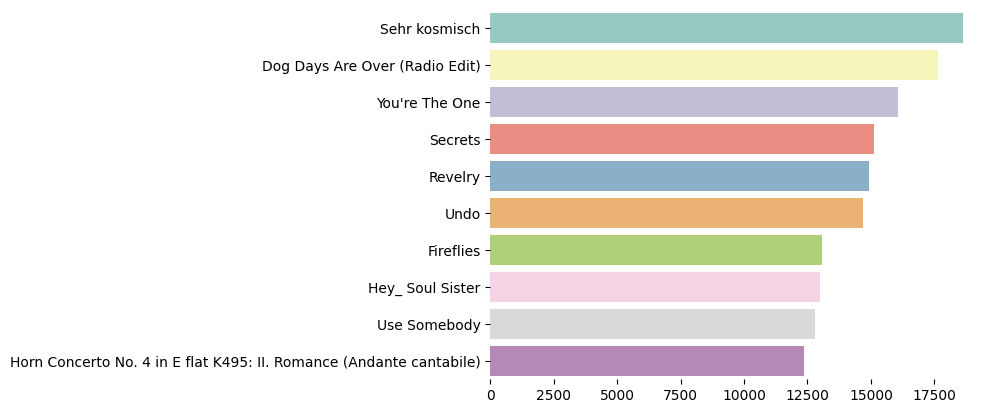

In [28]:
plt.figure()
sns.barplot(x=counts, y=labels, palette='Set3')
sns.despine(left=True, bottom=True)

In [29]:
#count how many rows we have by artist name, we show only the ten most popular artist 
ten_pop_artists  = dfPopularSongMetaDataMerged.groupby(['artist_name'])['play_count'].count().reset_index().sort_values(['play_count','artist_name'], ascending = [0,1])

In [30]:
ten_pop_artists = ten_pop_artists[:10]
ten_pop_artists

,artist_name,play_count
1686,Coldplay,125818
7505,The Black Keys,95067
7795,The Killers,74316
3594,Jack Johnson,72891
4298,Kings Of Leon,69684
6245,Radiohead,69342
1908,Daft Punk,64997
5467,Muse,64687
2850,Florence + The Machine,61106
5202,Metallica,46141


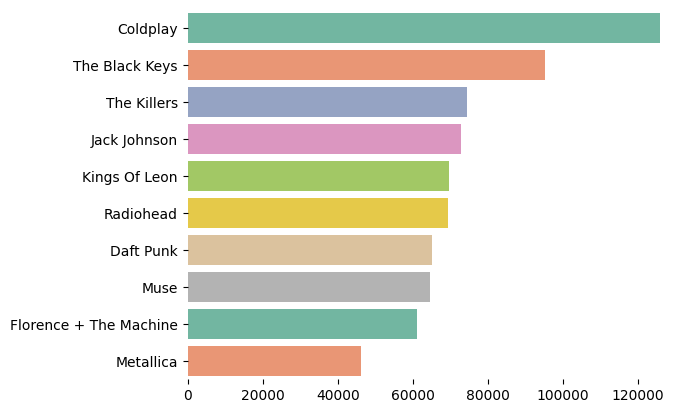

In [31]:
plt.figure()
labels = ten_pop_artists['artist_name'].tolist()
counts = ten_pop_artists['play_count'].tolist()
sns.barplot(x=counts, y=labels, palette='Set2')
sns.despine(left=True, bottom=True)

In [32]:
listen_counts = pd.DataFrame(dfPopularSongMetaDataMerged.groupby('play_count').size(), columns=['count'])

In [33]:
print(f"The maximum time the same user listened to the same songs was: {listen_counts.reset_index(drop=False)['play_count'].iloc[-1]}")

The maximum time the same user listened to the same songs was: 9667


In [34]:
print(f"On average, a user listen to the same song {dfPopularSongMetaDataMerged['play_count'].mean()} times")

On average, a user listen to the same song 4.095210030889434 times


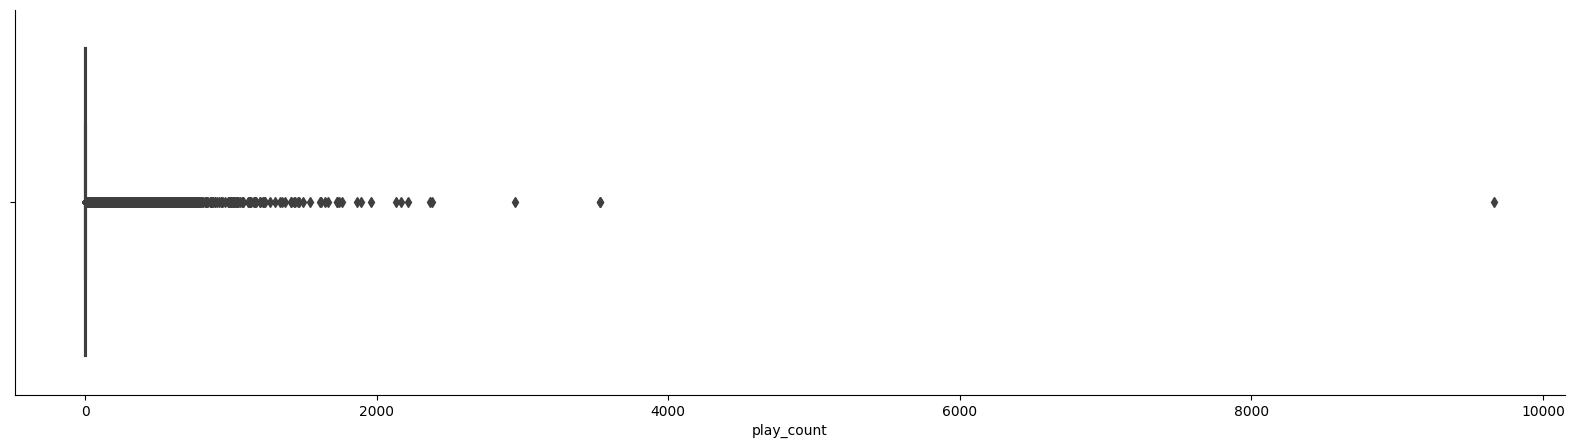

In [35]:
plt.figure(figsize=(20, 5))
sns.boxplot(x='play_count', data=dfPopularSongMetaDataMerged)
sns.despine()

In [36]:
listen_counts_temp = listen_counts[listen_counts['count'] > 50].reset_index(drop=False)

In [37]:
song_user = dfPopularSongMetaDataMerged.groupby('user')['songid'].count()

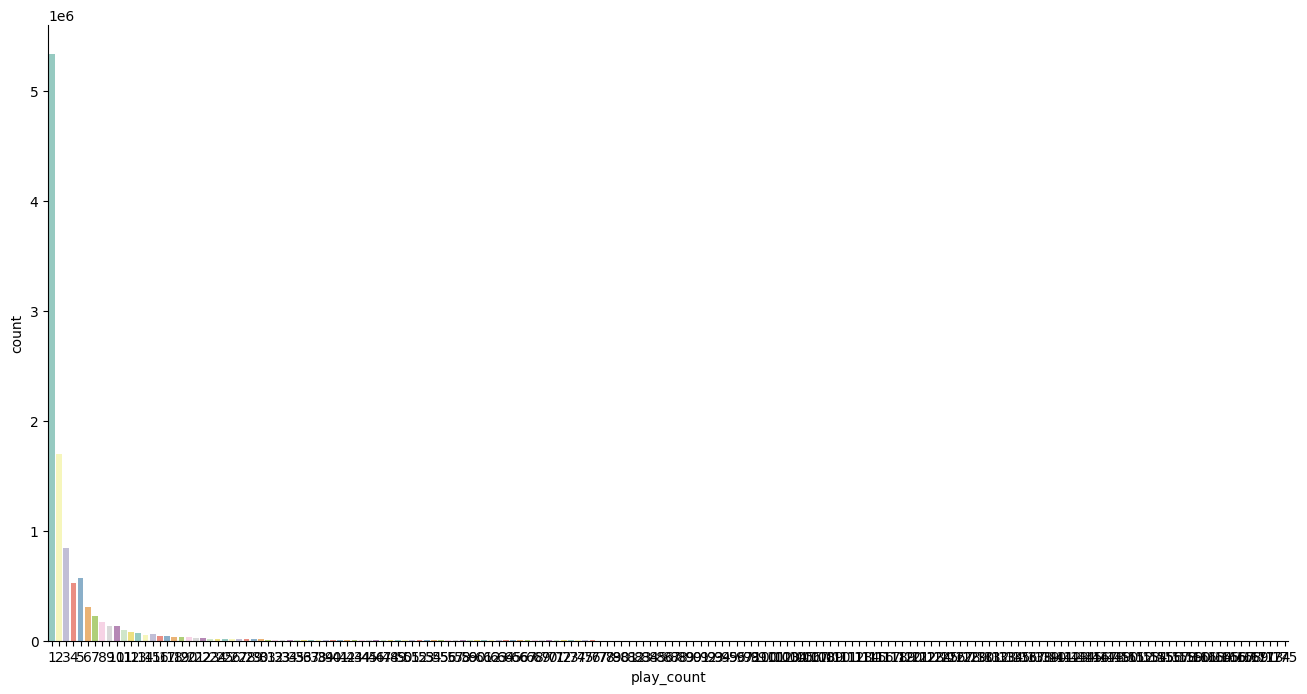

In [38]:
plt.figure(figsize=(16, 8))
sns.barplot(x='play_count', y='count', palette='Set3', data=listen_counts_temp)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show();

C:\Users\soni2\AppData\Local\Temp\ipykernel_22304\2530348831.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(song_user.values, color='orange')


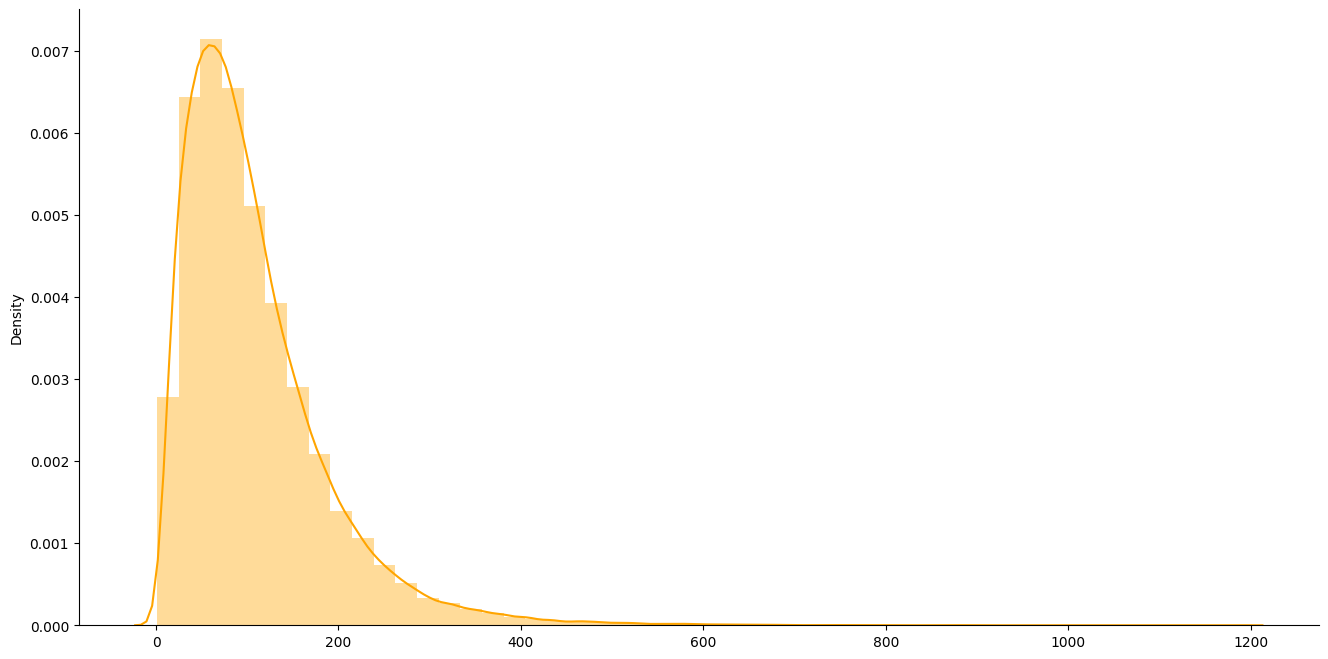

In [39]:
plt.figure(figsize=(16, 8))
sns.distplot(song_user.values, color='orange')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show();

In [40]:
print(f"A user listens to an average of {np.mean(song_user)} songs")

A user listens to an average of 107.74988999559983 songs


In [41]:
print(f"A user listens to an average of {np.median(song_user)} songs, with minimum {np.min(song_user)} and maximum {np.max(song_user)} songs")

A user listens to an average of 89.0 songs, with minimum 1 and maximum 1189 songs


## Preparing the Data

In [42]:
# Get users which have listen to at least 16 songs
x = dfPopularSongMetaDataMerged.groupby('user').count()['play_count'] > 200
padhe_likhe_users = x[x].index
filtered_rating = dfPopularSongMetaDataMerged[dfPopularSongMetaDataMerged['user'].isin(padhe_likhe_users)]

In [43]:
# filtered_rating = filtered_rating.rename(columns={'song': 'songid'})
filtered_rating

,user,songid,title,play_count,release,artist_name,year
58,5a905f000fc1ff3df7ca807d57edb608863db05d,SOAFOBL12AF72A25BA,Grandfather Clock,12,Young Mountain,This Will Destroy You,2006
59,5a905f000fc1ff3df7ca807d57edb608863db05d,SOAFTRR12AF72A8D4D,Harder Better Faster Stronger,1,Discovery,Daft Punk,2007
60,5a905f000fc1ff3df7ca807d57edb608863db05d,SOAIILB12A58A776F7,Phantom Part 1.5 (Album Version),3,A Cross The Universe,Justice,0
61,5a905f000fc1ff3df7ca807d57edb608863db05d,SOAIIYK12A6D4F6666,Human After All (Alter Ego Remix ),1,Human After All,Daft Punk,2005
62,5a905f000fc1ff3df7ca807d57edb608863db05d,SOAJJDS12A8C13A3FB,I Got Mine,1,Attack & Release,The Black Keys,2008
...,...,...,...,...,...,...,...
10774545,8305c896f42308824da7d4386f4b9ee584281412,SOZDGEW12A8C13E748,One,4,...And Justice For All,Metallica,1988
10774546,8305c896f42308824da7d4386f4b9ee584281412,SOZEETS12AC9071BD3,Favorite Girl,1,My World,Justin Bieber,2009
10774547,8305c896f42308824da7d4386f4b9ee584281412,SOZKNSB12A8C140F11,Replay,1,Massive R&B Spring 2010,Iyaz,2009
10774548,8305c896f42308824da7d4386f4b9ee584281412,SOZVCRW12A67ADA0B7,When You Were Young,2,When You Were Young,The Killers,2006


In [44]:
y = filtered_rating.groupby('title').count()['user']>=100
famous_songs = y[y].index
final_ratings = filtered_rating[filtered_rating['title'].isin(famous_songs)]

In [45]:
final_ratings.shape

(2194493, 7)

In [46]:
df_songs_features = final_ratings.pivot_table(index='songid',columns='user',values='play_count')
df_songs_features.fillna(0,inplace=True)
df_songs_features

user,00043d7bc800ceff4a90459e189eba5d442a1d3d,000d80cd9b58a8f77b33aa613dcfc5cbf1daf5e8,00106661302d2251d8bb661c91850caa65096457,001889ee41b5f31c404a1abe4af07b2377fa776b,001fd039ab4472039d22f9481bb5c5d376c3032f,0025bfe6248070545d23721083acd3f60451da4f,002abc31db3d2d789395e728461156f1928a5a62,002b63a7e2247de6d62bc62f253474edc7dd044c,0033ce7d7aeece5454994a0b858c0b4b92669394,00375ed2273e3d54a45a6b3b26df45a2a1e6f89c,...,ffc3aa03fb03a2a2d1c034b659f7f0a02302744e,ffd3f3d8810d319062c6273eed7aa55939a74e17,ffd458f903d49854685cf4540245c1d297e8bafa,ffd9e1af2656cfa450b9487dd51dddb83b25e306,ffdaab327f2fc6b9fa01a4e3e7f41fdd0e468046,ffebd721100a7bf2266bc9e8b6ad881e41e270d3,ffef74cdcb743c3074fd63540d2bef7d445c6dff,fff03efd1550136063389fa71125194614e1c68f,fff90dcb01432ff9b9b837ed9af3c533d533fa22,fffb0b218640d86e5cb99d41cd3ecad977142da5
songid,,,,,,,,,,,,,,,,,,,,,
SOAACPJ12A81C21360,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOAAFAC12A67ADF7EB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOAAGFH12A8C13D072,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOAAISU12AF72A44D3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOAALFT12A8C134574,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SOZZRHE12A6702165F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOZZTNF12A8C139916,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOZZVWB12AB0189C30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
# obtain a sparse matrix
mat_songs_features = csr_matrix(df_songs_features.values)

In [48]:
df_unique_songs = dfPopularSongMetaDataMerged.drop_duplicates(subset=['songid']).reset_index(drop=True)[['songid', 'title']]
# df_unique_songs = df_unique_songs.rename(columns={'song': 'songid'})


In [49]:
decode_id_song = {
    song: i for i, song in 
    enumerate(list(df_unique_songs.set_index('songid').loc[df_songs_features.index].title))
}

In [50]:
class Recommender:
    def __init__(self, metric, algorithm, k, data, decode_id_song):
        self.metric = metric
        self.algorithm = algorithm
        self.k = k
        self.data = data
        self.decode_id_song = decode_id_song
        self.data = data
        self.model = self._recommender().fit(data)
    
    def make_recommendation(self, new_song, n_recommendations):
        # print(1)
        recommended = self._recommend(new_song=new_song, n_recommendations=n_recommendations)
        print("... Done")
        return recommended 
    
    def _recommender(self):
        # print(2)
        return NearestNeighbors(metric=self.metric, algorithm=self.algorithm, n_neighbors=self.k, n_jobs=-1)
    
    def _recommend(self, new_song, n_recommendations):
        # print(3)
        # Get the id of the recommended songs
        recommendations = []
        recommendation_ids = self._get_recommendations(new_song=new_song, n_recommendations=n_recommendations)
        # print("These are the recommendation ids: " , recommendation_ids
        # print("This is the return value " , recommendation_ids)
        # return the name of the song using a mapping dictionary
        recommendations_map = self._map_indeces_to_song_title(recommendation_ids)
        # print("this is the return value", recommendations_map)
        # Translate this recommendations into the ranking of song titles recommended
        # print(7)
        for i, (idx, dist) in enumerate(recommendation_ids):
            if(idx in recommendations_map):
                recommendations.append(recommendations_map[idx])
        return recommendations

                 
    def _get_recommendations(self, new_song, n_recommendations):
        # print(4)
        # Get the id of the song according to the text
        recom_song_id = self._fuzzy_matching(songname=new_song)
        # Start the recommendation process
        print(f"Starting the recommendation process for {new_song} ...")
        # recom_song_id = self.data[recom_song_id].reshape(1, -1)
        # Return the n neighbors for the song id
        distances, indices = self.model.kneighbors(self.data[recom_song_id], n_neighbors=n_recommendations+1)
        return sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    
    def _map_indeces_to_song_title(self, recommendation_ids):
        # print(5)
        # get reverse mapper
        return {songid: song_title for song_title, songid in self.decode_id_song.items()}
    
    def _fuzzy_matching(self, songname):
        # print(6)
        match_tuple = []
        # get match
        for title, idx in self.decode_id_song.items():
            ratio = fuzz.ratio(title.lower(), songname.lower())
            if ratio >= 60:
                match_tuple.append((title, idx, ratio))
        # sort
        match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
        if not match_tuple:
            print(f"The recommendation system could not find a match for {songname}")
            return
        return match_tuple[0][1]

In [51]:
model = Recommender(metric='cosine', algorithm='brute', k=20, data=mat_songs_features, decode_id_song=decode_id_song)

In [63]:
songname = input("Enter the song name: ")

In [64]:
new_recommendations = model.make_recommendation(new_song= songname, n_recommendations=10)

Starting the recommendation process for Roar ...
... Done


In [65]:
# print(f"The recommendations for {songname} are:")
# print("{new_recommendations}")
print(f"\n-------------------------------------- \
\nRecommendation for song name: {songname} \n--------------------------------------\n")
rank_value = 1
for i, item in enumerate(new_recommendations, start=1):
    print(f"{i}. {item}")


-------------------------------------- 
Recommendation for song name: Roar 
--------------------------------------

1. Good Love Is On The Way
2. Droomland (duet met Paul de Leeuw)
3. Friends_ Lovers Or Nothing
4. All About The Benjamins (Album Version)
5. Mr. Pitiful
